2025-06-07 15:09:16.474888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749323356.491144 3418117 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749323356.496511 3418117 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749323356.509468 3418117 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749323356.509482 3418117 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749323356.509484 3418117 computation_placer.cc:177] computation placer alr

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Cosmology: {'omega_cold': 0.3127949594594728, 'omega_baryon': 0.05717195839822765, 'hubble': 0.7394736058118728, 'sigma8_cold': 0.7460101491409004, 'ns': 1.007806011647308, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'omega_m': 0.3127949594594728}


/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to 

Saved plot to plots/pk_bacco.pdf


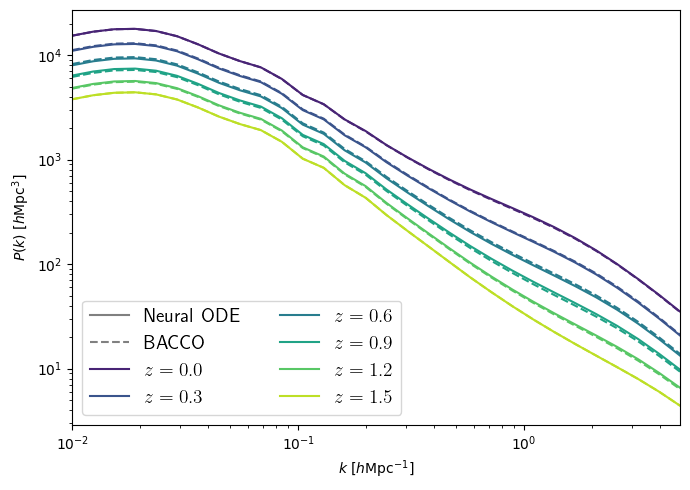

In [1]:
# inference_and_plot.py

import os
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import baccoemu

# --- BACCO emulator setup ---
bacco = baccoemu.Matter_powerspectrum()
k_full = np.logspace(-2, np.log10(bacco.emulator["nonlinear"]["k"].max()), 30)
k = k_full
k_shp = len(k)

# --- Random cosmology ---
rng = np.random.default_rng(seed=42)
params = {
    'omega_cold': rng.uniform(0.23, 0.4) - rng.uniform(0.04, 0.06),
    'omega_baryon': rng.uniform(0.04, 0.06),
    'hubble': rng.uniform(0.6, 0.8),
    'sigma8_cold': rng.uniform(0.73, 0.9),
    'ns': rng.uniform(0.92, 1.01),
    'neutrino_mass': 0.0,
    'w0': -1.0,
    'wa': 0.0
}
params['omega_m'] = params['omega_cold'] 

print("Cosmology:", params)

# --- Compute P(k,z) from BACCO ---
def get_nonlinear_pk(z):
    params["expfactor"] = 1.0 / (1.0 + z)
    _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
    return pk

# --- Background ---
G = 4.30091e-9
def Hz_func(z):
    Om = params['omega_m']
    h = params['hubble']
    return 100. * h * jnp.sqrt(Om * (1 + z) ** 3 + (1 - Om))

def rho_m_func(z):
    Om = params['omega_m']
    h = params['hubble']
    rho_crit_0 = 3 * (100. * h) ** 2 / (8 * jnp.pi * G)
    return Om * rho_crit_0 * (1 + z) ** 3

# --- Load normalization data ---
norm = np.load("/srv/scratch3/taylor.4264/odd_emu/production_run_bacco/merged/logpk_data.npz")
Hz_all = norm["Hz"]
rho_m_all = norm["rho_m"]
H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_all = np.log10(rho_m_all + 1e-30)
rho_mean, rho_std = log_rho_all.mean(), log_rho_all.std()

def H_norm(z):
    return (Hz_func(z) - H_mean) / H_std

def rho_norm(z):
    return (jnp.log10(rho_m_func(z) + 1e-30) - rho_mean) / rho_std

# --- Initial condition ---
z0, z1 = 1.5, 0.0
ts = jnp.linspace(z0, z1, 20)
logpk0 = jnp.log(get_nonlinear_pk(z0).astype(jnp.float32))

# --- Define model ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)
    
    def __call__(self, P, H, rho, z):
        H = jnp.atleast_1d(H)
        rho = jnp.atleast_1d(rho)
        z = jnp.atleast_1d(z)
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Solve with multiple models ---
model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final_bacco"
all_pk = []

def rhs(z, logP, args):
    model, = args
    return model(logP, H_norm(z), rho_norm(z), z)

for i in range(10):
    path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(path, model)
    model = eqx.combine(model_params, model)

    sol = diffeqsolve(
        ODETerm(rhs),
        Tsit5(),
        t0=z0,
        t1=z1,
        dt0=-1e-2,
        y0=logpk0,
        args=(model,),
        saveat=SaveAt(ts=ts)
    )
    all_pk.append(jnp.exp(sol.ys))

pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

# --- Plot ---
z_list = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(z_list)))
plt.figure(figsize=(7, 5))

for i, z in enumerate(z_list):
    z_idx = int(jnp.argmin(jnp.abs(ts - z)))
    pk_pred = pk_mean[z_idx]
    pk_true = get_nonlinear_pk(z)

    plt.plot(k, pk_pred, color=colors[i], ls='-')
    plt.plot(k, pk_true, color=colors[i], ls='--')

# Axes settings
import matplotlib as mpl
from matplotlib import rcParams

plt.rc('text', usetex=True)


# Set global font sizes
rcParams.update({
    "legend.fontsize": 18,         # Legend text
    "axes.labelsize": 24,          # Axis labels
    "xtick.labelsize": 18,         # X-axis tick labels
    "ytick.labelsize": 18          # Y-axis tick labels
})

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k\ [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k)\ [ h \mathrm{Mpc}^3]$")
plt.xlim(k.min(), k.max())

# Legend
style_handles = [
    Line2D([0], [0], color='gray', ls='-', label='Neural ODE'),
    Line2D([0], [0], color='gray', ls='--', label='BACCO')
]
color_handles = [
    Line2D([0], [0], color=colors[i], ls='-', label=fr'$z={z}$')
    for i, z in enumerate(z_list)
]
plt.legend(handles = style_handles + color_handles, fontsize=14, ncol=2, loc='lower left')
plt.tight_layout()
plt.savefig("plots/pk_bacco.pdf")
print("Saved plot to plots/pk_bacco.pdf")

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
from matplotlib import pyplot as plt
import os

plt.rc('text', usetex=True)
plt.rcParams.update({
    "legend.fontsize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

# --- Load emulator and k ---
bacco = baccoemu.Matter_powerspectrum()
k_full = np.logspace(-2, np.log10(bacco.emulator["nonlinear"]["k"].max()), 30)
k = k_full
k_shp = len(k)


# --- Load normalization data ---
data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
norm_data = np.load(os.path.join(data_dir, "logpk_data_with_dHz_dz.npz"))
Hz_all = norm_data["Hz"]
rho_m_all = norm_data["rho_m"]
dHz_dz_all = norm_data["dHz_dz"]

H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_mean, log_rho_std = np.log10(rho_m_all + 1e-30).mean(), np.log10(rho_m_all + 1e-30).std()
dH_mean, dH_std = dHz_dz_all.mean(), dHz_dz_all.std()

# --- Constants ---
G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

# --- Model RHS function ---
def rhs(z, logP, args):
    model, H_norm, rho_norm, dHz_norm = args
    H_z = jnp.atleast_1d(H_norm(z))
    rho_z = jnp.atleast_1d(rho_norm(z))
    dHz_z = jnp.atleast_1d(dHz_norm(z))
    return model(logP, H_z, rho_z, dHz_z)

colors = plt.cm.viridis(np.linspace(0.1, 0.9, 10))

for j in range(10):
    rng = np.random.default_rng(seed=j)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)
    k_h_units = k / h

    # --- BACCO truth ---
    def get_nonlinear_pk(z):
        params["expfactor"] = 1.0 / (1.0 + z)
        _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
        return pk
    
    def get_bacco_logpk(z):
        return np.log(get_nonlinear_pk(z))

    # --- Background functions ---
    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3 * (1 + (-1.0)))
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        rho_crit = 3 * (100.0 * h)**2. / (8 * jnp.pi * G)
        return Omm * rho_crit * (1+z) ** 3.

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    def dHz_norm(z):
        H0 = 100.0 * h
        dEz2_dz = 3 * Omm * (1 + z)**2
        dH_dz = 0.5 * H0 * dEz2_dz / jnp.sqrt(Omm * (1 + z)**3 + (1 - Omm))
        return (dH_dz - dH_mean) / dH_std

    # --- ODE model definition ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, dH):
            x = jnp.concatenate([P, H, rho, dH])
            return self.mlp(x)

    # --- Load initial logP(k,z=5) ---
    z0, z1 = 1.5, 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_bacco_logpk(z0)

    # --- Average predictions over models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(4):
        path = os.path.join(model_dir, f"learned_model_logpk_dH_{i}.eqx")
        model = RHS()
        model = eqx.combine(eqx.tree_deserialise_leaves(path, model), model)

        sol = diffeqsolve(
            ODETerm(rhs),
            Tsit5(),
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model, H_norm, rho_norm, dHz_norm),
            saveat=SaveAt(ts=ts)
        )
        all_pk.append(jnp.exp(sol.ys))

    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)
    pk_z0_ode = pk_mean[-1]
    pk_z0_bacco = jnp.exp(get_bacco_logpk(0.0))
    residual = (pk_z0_ode - pk_z0_bacco) / pk_z0_bacco

    plt.plot(k, residual, color=colors[j])

plt.axhspan(-0.01, 0.01, color='gray', alpha=0.1)
plt.axhspan(-0.03, 0.03, color='gray', alpha=0.05)
plt.axhspan(-0.05, 0.05, color='gray', alpha=0.05)
plt.xscale("log")
plt.xlabel(r"$k\ [\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\Delta P(k)/P(k)$")
plt.ylim(-0.1, 0.1)
plt.tight_layout()
plt.savefig("plots/error.pdf")

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


AssertionError: Param expfactor=0.16666666666666666 out of bounds [0.4, 1.0]

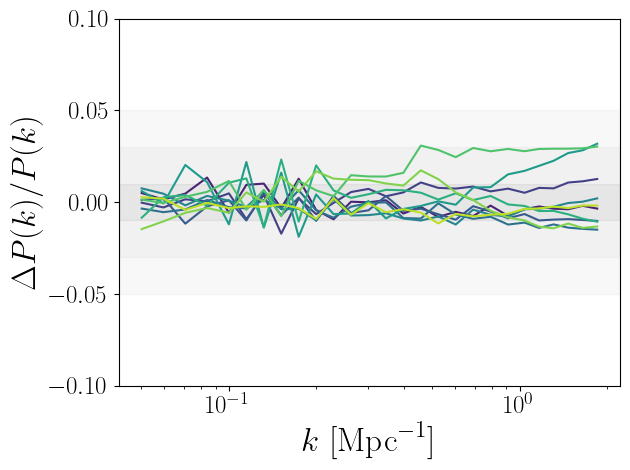

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
from matplotlib import pyplot as plt
import os

plt.rc('text', usetex=True)
plt.rcParams.update({
    "legend.fontsize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

# --- Load emulator and k ---
emulator = CosmoPowerJAX(probe="mpk_lin")
k_full = emulator.modes.astype(np.float32)
k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
k = k_full[k_idx]
k_shp = k.shape[0]

# --- Load normalization data ---
data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
norm_data = np.load(os.path.join(data_dir, "logpk_data_with_dHz_dz.npz"))
Hz_all = norm_data["Hz"]
rho_m_all = norm_data["rho_m"]
dHz_dz_all = norm_data["dHz_dz"]

H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_mean, log_rho_std = np.log10(rho_m_all + 1e-30).mean(), np.log10(rho_m_all + 1e-30).std()
dH_mean, dH_std = dHz_dz_all.mean(), dHz_dz_all.std()

# --- Constants ---
G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

# --- Model RHS function ---
def rhs(z, logP, args):
    model, H_norm, rho_norm, dHz_norm = args
    H_z = jnp.atleast_1d(H_norm(z))
    rho_z = jnp.atleast_1d(rho_norm(z))
    dHz_z = jnp.atleast_1d(dHz_norm(z))
    return model(logP, H_z, rho_z, dHz_z)

colors = plt.cm.viridis(np.linspace(0.1, 0.9, 10))

for j in range(10):
    rng = np.random.default_rng(seed=j)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    w = rng.uniform(-1.15, -0.85)
    wa = rng.uniform(-0.3, 0.3)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': w, 'wa': wa}
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)
    k_h_units = k / h

    # --- BACCO truth ---
    def get_nonlinear_pk(z):
        params["expfactor"] = 1.0 / (1.0 + z)
        _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
        return pk

    # --- Background functions ---
    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3 * (1 + (-1.0)))
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        rho_crit = 3 * (100.0 * h)**2. / (8 * jnp.pi * G)
        return Omm * rho_crit * (1+z) ** 3.

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    def dHz_norm(z):
        H0 = 100.0 * h
        dEz2_dz = 3 * Omm * (1 + z)**2
        dH_dz = 0.5 * H0 * dEz2_dz / jnp.sqrt(Omm * (1 + z)**3 + (1 - Omm))
        return (dH_dz - dH_mean) / dH_std

    # --- ODE model definition ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, dH):
            x = jnp.concatenate([P, H, rho, dH])
            return self.mlp(x)

    # --- Load initial logP(k,z=5) ---
    z0, z1 = 5.0, 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_bacco_logpk(z0)

    # --- Average predictions over models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(4):
        path = os.path.join(model_dir, f"learned_model_logpk_dH_{i}.eqx")
        model = RHS()
        model = eqx.combine(eqx.tree_deserialise_leaves(path, model), model)

        sol = diffeqsolve(
            ODETerm(rhs),
            Tsit5(),
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model, H_norm, rho_norm, dHz_norm),
            saveat=SaveAt(ts=ts)
        )
        all_pk.append(jnp.exp(sol.ys))

    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)
    pk_z0_ode = pk_mean[-1]
    pk_z0_bacco = jnp.exp(get_bacco_logpk(0.0))
    residual = (pk_z0_ode - pk_z0_bacco) / pk_z0_bacco

    plt.plot(k, residual, color=colors[j])

plt.axhspan(-0.01, 0.01, color='gray', alpha=0.1)
plt.axhspan(-0.03, 0.03, color='gray', alpha=0.05)
plt.axhspan(-0.05, 0.05, color='gray', alpha=0.05)
plt.xscale("log")
plt.xlabel(r"$k\ [\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\Delta P(k)/P(k)$")
plt.ylim(-0.1, 0.1)
plt.tight_layout()
plt.savefig("plots/error_w0wa.pdf")